# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import torch
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


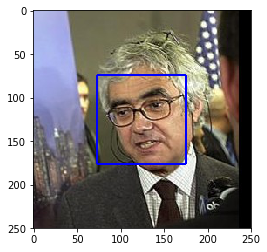

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plottingerror: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/objdetect/src/cascadedetect.cpp:1698: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def displayImage(img_path):
    img = cv2.imread(img_path)
    plt.imshow(img)

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#print([file for file in dog_files_short])

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


print("Percentage of the first 100 images that have a detected human face in human files: {}%".format(sum([1 if face_detector(image) else 0 for image in human_files_short])))
print("Percentage of the first 100 images that have a detected human face in dog files: {}%".format(sum([1 if face_detector(image) else 0 for image in dog_files_short])))


Percentage of the first 100 images that have a detected human face in human files: 100%
Percentage of the first 100 images that have a detected human face in dog files: 10%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [8]:
# Freeze training for all "features" layers
for param in VGG16.parameters():
    param.requires_grad = False

In [9]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    data_transform = transforms.Compose([transforms.Resize(224), 
                                         transforms.CenterCrop(224),
                                      transforms.ToTensor()])
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    img = Image.open(img_path)
    image = data_transform(img).unsqueeze(0) # This add the batch parameter (1, 3, 224, 224)
    
    if use_cuda:
        image = image.cuda()
    
    VGG16.eval()
    with torch.no_grad():
        output = VGG16(image)
        maxs, indices = torch.max(torch.exp(output), 1)  
    VGG16.train()
    #print("maxs = {} indices = {}".format(maxs, indices))
    return indices.item() # predicted class index

252


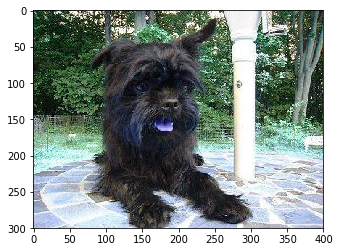

In [11]:
print(VGG16_predict("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg"))
displayImage("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if index >= 151 and index <= 268:
        return True
    
    return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

print("Percentage of dog dectected in human_files_short: {}%".format(sum([1 if dog_detector(image) else 0 for image in human_files_short])))
print("Percentage of dog detected in dog_files_short: {}%".format(sum([1 if dog_detector(image) else 0 for image in dog_files_short])))


Percentage of dog dectected in human_files_short: 0%
Percentage of dog detected in dog_files_short: 95%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

INCEPTIONV3 = models.inception_v3(pretrained=True)

if use_cuda:
    INCEPTIONV3.cuda()

for param in INCEPTIONV3.parameters():
    param.requires_grad = False


In [15]:
def INCEPTIONV3_predictor(image_path):
        #Preprocess
        img = Image.open(image_path)
        transform_data = transforms.Compose([transforms.Resize(299),
                                            transforms.CenterCrop(299),
                                            transforms.ToTensor()])
        
        image = transform_data(img).unsqueeze(0) #convert to batch, depth, height, weight
        
        if use_cuda:
            image = image.cuda()
        
        INCEPTIONV3.eval() #because it is testing
        with torch.no_grad():
            output = INCEPTIONV3(image)
            maxs, indices = torch.max(torch.exp(output), dim = 1)
        
        INCEPTIONV3.train()
        return indices.item()

In [16]:
def inceptionv3_doc_detector(image_path):
    index = INCEPTIONV3_predictor(image_path)
    if index >= 151 and index <= 268:
        return True
    return False

In [17]:

print("Percentage of dog dectected in human_files_short: {}%".format(sum([1 if inceptionv3_doc_detector(image) else 0 for image in human_files_short])))
print("Percentage of dog detected in dog_files_short: {}%".format(sum([1 if inceptionv3_doc_detector(image) else 0 for image in dog_files_short])))


Percentage of dog dectected in human_files_short: 0%
Percentage of dog detected in dog_files_short: 99%


In [18]:
RESNET =  models.resnet18(pretrained=True)

if use_cuda:
    RESNET.cuda()

for param in RESNET.parameters():
    param.requires_grad = False

In [19]:
def RESNET_predictor(image_path):
    # preprocess
    img = Image.open(image_path)
    data_transforms = transforms.Compose([transforms.Resize(224),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()])
    
    image = data_transforms(img).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    RESNET.eval()
    with torch.no_grad():
        output = RESNET(image)
        maxs, indices = torch.max(torch.exp(output), dim = 1)
        
    RESNET.train()
    return indices.item()

In [20]:
def RESNET_doc_detector(image_path):
    index = RESNET_predictor(image_path)
    if index >= 151 and index <= 268:
        return True
    return False

In [21]:
print("Percentage of dog dectected in human_files_short: {}%".format(sum([1 if RESNET_doc_detector(image) else 0 for image in human_files_short])))
print("Percentage of dog detected in dog_files_short: {}%".format(sum([1 if RESNET_doc_detector(image) else 0 for image in dog_files_short])))


Percentage of dog dectected in human_files_short: 1%
Percentage of dog detected in dog_files_short: 98%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [23]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define training and test data directories
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, "valid/")
test_dir = os.path.join(data_dir, 'test/')

#data_transforms = transforms.Compose([transforms.Resize(224),
#                                     transforms.CenterCrop(224),
#                                     transforms.ToTensor()])

sizetoCrop = 224
data_transforms_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(sizetoCrop),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ])

train_data = datasets.ImageFolder(train_dir, transform = data_transforms_train)

data_transforms_valid_test = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                              std=[0.5, 0.5, 0.5])])


valid_data = datasets.ImageFolder(valid_dir, transform = data_transforms_valid_test)
test_data = datasets.ImageFolder(test_dir, transform = data_transforms_valid_test)

print(f"# train_data = {len(train_data)}")
print(f"# valid_data = {len(valid_data)}")
print(f"# test_data = {len(test_data)}")

# define dataloader parameters
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, 
                                            num_workers = num_workers,
                                            shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size= batch_size,
                                            num_workers = num_workers,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)


print(f"# train_data = {len(train_loader)}")
print(f"# valid_data = {len(valid_loader)}")
print(f"# test_data = {len(test_loader)}")


# train_data = 6680
# valid_data = 835
# test_data = 836
# train_data = 334
# valid_data = 42
# test_data = 42


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- We use the module transforms, which uses a method Compose that receives a list as a parameter and each element of the list represents: 
    - transforms.RandomResizeCrop(224) -> Randomly Resize and Crop the images with de dimession of 224*224
    - transforms.CenterCrop(224) -> Crop the image in the center with dimession 224*224
    - transforms.ToTensor() -> Convert the numpy array to Tensor
- Yes. One of the parameters passed to the Compose method is transforms.RandomRotation(90), which rotate the Image randomly 90 grades each time.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # image = 224*224*3
        self.conv1 = nn.Conv2d(3, 112, 3, padding=1)
        # conv kernel = 3*3*3
        # output volumen = 224*224*112
        # output image after pooling = 112*112*112
        self.conv2 = nn.Conv2d(112, 192, 3, padding=1)
        # conv kernel =  3*3*112
        # output volumen = 112*112*192
        # output image after pooling = 56*56*192
        self.conv3 = nn.Conv2d(192, 512, 3,  padding=1)
        # conv kernal = 3*3*192
        # output volumen = 56*56*192
        # output image after pooling = 28*28*512
        self.conv4 = nn.Conv2d(512, 512, 3, padding=1)
        # conv kernal = 3*3*512
        # output volumen = 28*28*512
        # output image after pooling = 14*14*512
        
        self.pool = nn.MaxPool2d(2,2)
        self.batchNorm = nn.BatchNorm2d(112)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(112)
        self.conv_bn3 = nn.BatchNorm2d(192)
        self.conv_bn4 = nn.BatchNorm2d(512)
    
        self.fc1 = nn.Linear(512*14*14, 500)
        self.fc2 = nn.Linear(500, 700)
        self.fc3 = nn.Linear(700, 900)
        self.fc4 = nn.Linear(900, 1000)
        
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv4(x))))
        
        x = x.view(-1, 512*14*14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(self.fc4(x))
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
model_scratch

Net(
  (conv1): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(112, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchNorm): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=700, bias=Tru

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have chosen the MaxPool(2,2) which means I will be reducing the size of the output volumen in a half each time we apply the MaxPool to the Conv Layer.

These are the steps I followed:

- The input image dimensions are: 224 * 224 * 3
- The convolutional kernel will have the dimensions 3 * 3 * 3
- (W-F+2(P))/S +1 == (224 - 3 + 2)/1 + 1 = 224 ===> 224 * 224 * 112
- The output size after applying the MaxPool would be: (weight=112)*(height=112)*(depth=112) I have chosen the depth equal to the image size divided by 2. 



- The first convolutional layer has the size of 112 * 112 * 112.
- The depth chosen for the second convolutional layer is 192.
- (W-F+2(P))/S +1 == (112 - 3 + 2)/1 + 1 = 112
- The output size after applying the MaxPool would be: 56 * 56 * 192 (The second convolutional layer)



- The second convolutional layer has the size of 56 * 56 * 192.
- The depth chosen for the third convolutonal layer is 512.
- (W-F+2(P))/S +1 == (56 - 3 + 2)/1 + 1 = 56
- The output size after applying the MaxPool would be: 28 * 28 * 512

- The third convolutional layer has the size of 28 * 28 * 512
- The depth chosen for the fourth convolutional layer is 512.
- (W-F+2(P))/S +1 == (28 - 3 + 2)/1 + 1 = 28
- The output size after applying the MaxPool would be: 14 * 14 * 512 and this is the size which will be the input of the fully connected network.



- The first Fully Connected Layer would have dimensions of: (512 * 14 * 14, 500) which is the output of the CNN.
- The second Fully Connected Layer would have dimensions of: (500, 700).
- The second Fully Connected Layer would have dimensions of: (700, 900).
- The second Fully Connected Layer would have dimensions of: (900, 1000), where 1000 is the number of categories or classes of dogs that are analyzed. 

- We use nn.Dropout(p=0.2) in order to remove the 20% of the inputs in each layer and force weights to learn more about the net.

- In addition, We use nn.BatchNorm2d(n_input) in order to apply batch normalization to each convolutional layer.

- We also apply the rectified unit function (F.relu) to each convolutional layer and fully connected layer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [25]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [26]:
# the following import is required for training to be robust to truncated images
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))  
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreassed {:.6f} --> {:.6f}"
                 .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model



In [27]:
#config0
start = time.time()

# create dict loaders_scratch
loaders_scratch = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

# train the model
model_scratch = train(50, loaders_scratch, 
                      model_scratch, 
                      optimizer_scratch, 
                      criterion_scratch, 
                      use_cuda, 
                      "model_scratch.pt")

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

end = time.time()
elapsed_time = end - start
print("Creating a file")
f= open("success_train_scratch.txt","w+")
f.write("Elapsed Time: {}".format(elapsed_time))
f.write("Finished!!!")
f.close()

Epoch: 1 	Training Loss: 0.000953 	Validation Loss: 5.461652
Validation loss decreassed inf --> 5.461652
Epoch: 2 	Training Loss: 0.000814 	Validation Loss: 5.062708
Validation loss decreassed 5.461652 --> 5.062708
Epoch: 3 	Training Loss: 0.000785 	Validation Loss: 4.749914
Validation loss decreassed 5.062708 --> 4.749914
Epoch: 4 	Training Loss: 0.000765 	Validation Loss: 4.609364
Validation loss decreassed 4.749914 --> 4.609364
Epoch: 5 	Training Loss: 0.000757 	Validation Loss: 4.658349
Epoch: 6 	Training Loss: 0.000752 	Validation Loss: 4.473528
Validation loss decreassed 4.609364 --> 4.473528
Epoch: 7 	Training Loss: 0.000738 	Validation Loss: 4.392573
Validation loss decreassed 4.473528 --> 4.392573
Epoch: 8 	Training Loss: 0.000727 	Validation Loss: 4.458988
Epoch: 9 	Training Loss: 0.000717 	Validation Loss: 4.262671
Validation loss decreassed 4.392573 --> 4.262671
Epoch: 10 	Training Loss: 0.000714 	Validation Loss: 4.292314
Epoch: 11 	Training Loss: 0.000716 	Validation Loss

elapsed_time = 407.0 min, 24443.141736507416 sec

In [29]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
model_scratch

Net(
  (conv1): Conv2d(3, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(112, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchNorm): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=700, bias=Tru

In [30]:
len(loaders_scratch['train'].dataset)


6680

In [31]:
len(loaders_scratch['train'])

334

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [32]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [33]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.924510


Test Accuracy: 27% (234/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [34]:
## TODO: Specify data loaders


import os
from torchvision import datasets

train_on_gpu  = torch.cuda.is_available()

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define training and test data directories
data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, "valid/")
test_dir = os.path.join(data_dir, 'test/')

data_transforms_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(sizetoCrop),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ])

train_data = datasets.ImageFolder(train_dir, transform = data_transforms_train)

data_transforms_valid_test = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                              std=[0.5, 0.5, 0.5])])


valid_data = datasets.ImageFolder(valid_dir, transform = data_transforms_valid_test)
test_data = datasets.ImageFolder(test_dir, transform = data_transforms_valid_test)

print(f"# train_data = {len(train_data)}")
print(f"# valid_data = {len(valid_data)}")
print(f"# test_data = {len(test_data)}")

# define dataloader parameters
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, 
                                            num_workers = num_workers,
                                            shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size= batch_size,
                                            num_workers = num_workers,
                                            shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size,
                                           num_workers = num_workers,
                                           shuffle = True)


print(f"# train_data = {len(train_loader)}")
print(f"# valid_data = {len(valid_loader)}")
print(f"# test_data = {len(test_loader)}")


# train_data = 6680
# valid_data = 835
# test_data = 836
# train_data = 105
# valid_data = 14
# test_data = 14


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [35]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [36]:
#"Freeze" all the parameters, so the net acts as a fixed feature extractor
for param in model_transfer.parameters():
    param.requires_grad = False

In [37]:
#Remove the last layer and update it with the current information
n_input = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_input, 1000)

#Replace the last layer with a linear classifier of our own
model_transfer.classifier[6] = last_layer

if train_on_gpu:
    model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

We use GVV-16 Convolution Neural Network because it has very good performance and is state of the art in image recognition. 

- First, we instatiate the GVV16 model in a variable model_transfer.
- We disabled the required gradient, because we do not want to modify the weights that have already been trained.
- Then, We modify the last Fully Connected Layer in order to output 1000 categories or classes.
- In the next step. We create the instance of CrossEntropyLoss and Stochastic Gradient Descend in order to reduce the loss error and optimize the networks when training.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [38]:
import torch.nn as nn
import torch.optim as optim

# Loss function
criterion_transfer = nn.CrossEntropyLoss()

# Optimizer function (Stochastic Gradient Descend)
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [48]:
# create dict loaders_scratch
loaders_transfer = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

In [41]:
def train2(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        #train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders["train"]):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))  
 
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(loaders['train'].dataset) 
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreassed {:.6f} --> {:.6f}"
                .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [43]:
import time

local_train_on_gpu = torch.cuda.is_available()
if local_train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")
    model_transfer
start = time.time()
# train the model
n_epochs = 30
# train the model
model_transfer = train2(n_epochs, loaders_transfer, , optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
end = time.time()
elapsed_time = end - start
print("elapsed_time = {} min, {} sec".format(elapsed_time//60, elapsed_time))

Training on GPU
Epoch: 1 	Training Loss: 0.000686 	Validation Loss: 2.350580
Validation loss decreassed inf --> 2.350580
Epoch: 2 	Training Loss: 0.000378 	Validation Loss: 1.377686
Validation loss decreassed 2.350580 --> 1.377686
Epoch: 3 	Training Loss: 0.000295 	Validation Loss: 1.045711
Validation loss decreassed 1.377686 --> 1.045711
Epoch: 4 	Training Loss: 0.000251 	Validation Loss: 0.893114
Validation loss decreassed 1.045711 --> 0.893114
Epoch: 5 	Training Loss: 0.000231 	Validation Loss: 0.800591
Validation loss decreassed 0.893114 --> 0.800591
Epoch: 6 	Training Loss: 0.000219 	Validation Loss: 0.730272
Validation loss decreassed 0.800591 --> 0.730272
Epoch: 7 	Training Loss: 0.000206 	Validation Loss: 0.686155
Validation loss decreassed 0.730272 --> 0.686155
Epoch: 8 	Training Loss: 0.000202 	Validation Loss: 0.655282
Validation loss decreassed 0.686155 --> 0.655282
Epoch: 9 	Training Loss: 0.000196 	Validation Loss: 0.629429
Validation loss decreassed 0.655282 --> 0.629429

In [54]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [55]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [56]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [61]:
#config2
## TODO: Specify model architecture 
model_transfer2 = models.vgg16(pretrained=True)

if use_cuda:
    model_transfer2 = model_transfer.cuda()


#"Freeze" all the parameters, so the net acts as a fixed feature extractor
for param in model_transfer2.parameters():
    param.requires_grad = False

#Remove the last layer and update it with the current information
n_input = model_transfer2.classifier[6].in_features
last_layer = nn.Linear(n_input, 1000)

#Replace the last layer with a linear classifier of our own
model_transfer2.classifier[6] = last_layer

if train_on_gpu:
    model_transfer2.cuda()
    
# Loss function
criterion_transfer2 = nn.CrossEntropyLoss()

# Optimizer function (Stochastic Gradient Descend)
optimizer_transfer2 = optim.SGD(model_transfer2.parameters(), lr = 0.01)

In [62]:
local_train_on_gpu = torch.cuda.is_available()
if local_train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")
    
start = time.time()
# train the model
n_epochs2 = 50
# train the model
model_transfer2 = train2(n_epochs2, loaders_transfer, model_transfer2, optimizer_transfer2, criterion_transfer2, use_cuda, 'model_transfer2.pt')
end = time.time()
elapsed_time = end - start
print("elapsed_time = {} min, {} sec".format(elapsed_time//60, elapsed_time))

Training on GPU
Epoch: 1 	Training Loss: 0.000705 	Validation Loss: 2.429429
Validation loss decreassed inf --> 2.429429
Epoch: 2 	Training Loss: 0.000384 	Validation Loss: 1.394581
Validation loss decreassed 2.429429 --> 1.394581
Epoch: 3 	Training Loss: 0.000294 	Validation Loss: 1.053218
Validation loss decreassed 1.394581 --> 1.053218
Epoch: 4 	Training Loss: 0.000255 	Validation Loss: 0.897474
Validation loss decreassed 1.053218 --> 0.897474
Epoch: 5 	Training Loss: 0.000234 	Validation Loss: 0.799274
Validation loss decreassed 0.897474 --> 0.799274
Epoch: 6 	Training Loss: 0.000217 	Validation Loss: 0.733974
Validation loss decreassed 0.799274 --> 0.733974
Epoch: 7 	Training Loss: 0.000211 	Validation Loss: 0.689854
Validation loss decreassed 0.733974 --> 0.689854
Epoch: 8 	Training Loss: 0.000201 	Validation Loss: 0.659694
Validation loss decreassed 0.689854 --> 0.659694
Epoch: 9 	Training Loss: 0.000193 	Validation Loss: 0.626885
Validation loss decreassed 0.659694 --> 0.626885

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [47]:
#config0 30 epochs
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.493136


Test Accuracy: 84% (704/836)


In [64]:
#config1 50 epochs
test(loaders_transfer, model_transfer2, criterion_transfer, use_cuda)

Test Loss: 0.464245


Test Accuracy: 83% (700/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [67]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def transfer_model_predict(img_path, model):
    data_transform = transforms.Compose([transforms.Resize(224), 
                                         transforms.CenterCrop(224),
                                      transforms.ToTensor()])
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    img = Image.open(img_path)
    image = data_transform(img).unsqueeze(0) # This add the batch parameter (1, 3, 224, 224)

    if use_cuda:
        image = image.cuda()
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        maxs, indices = torch.max(torch.exp(output), 1)  
    model.train()
    #print("index = ",indices.item())
    #print("maxs = {} indices = {}".format(maxs, indices))
    return indices.item() # predicted class index

In [68]:
#ForFun! 
#Helper function to return the dictionary from dictionary.txt
from pprint import pprint as pp

f = open("dictionary.txt", mode="rt", encoding="utf-8")
dogs_breed = {}
sep = ":"
for line in f:
    #print(line)
    lista = line.split(sep)
    left = lista[0].strip()
    right = lista[1].strip()
    #print("left = {}, right = {}".format(left, right))
    if "{" in left:
        right = right[1:-2] # removiendo "," y "'"
        dogs_breed[0] = right
        #print("dogs_breed = ", dogs_breed)
    elif "}" in right:
        right = right[1:-2]
        dogs_breed[999] = right # removiendo "}" y "'"
        #print("dogs_breed = ", dogs_breed)
    else:
        left_index = int(left[:])
        right_value = right[1:-2]
        dogs_breed[left_index] = right_value
        
f.close()

In [69]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

data_transfer = loaders_transfer.copy()

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    index = transfer_model_predict(img_path, model_transfer)
    #print(index)
    breed = class_names[index]
    return breed

In [71]:
data_transfer2 = loaders_transfer.copy()

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names2 = [item[4:].replace("_", " ") for item in data_transfer2['train'].dataset.classes]

def predict_breed_transfer2(img_path):
    # load the image and return the predicted breed
    index = transfer_model_predict(img_path, model_transfer2)
    #print(index)
    breed = class_names2[index]
    return breed

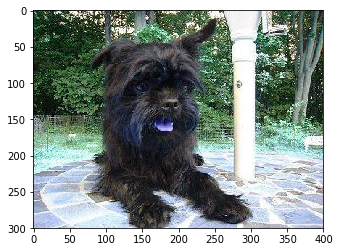

In [70]:
predict_breed_transfer("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")
displayImage("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [72]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    msg = ""
    if dog_detector(img_path):
        breed = predict_breed_transfer(img_path)
        msg = "Dogface has been detected!\nThe breed is: {}".format(breed)
    elif face_detector(img_path):
        breed = predict_breed_transfer(img_path)
        msg = "A human face(s) has/have been detected!\nThe Human face resembles the dog breed: {}".format(breed)
    else:
        msg = "Neither dog or human faces were detected!"
    return msg

In [73]:
def run_app2(img_path):
    ## handle cases for a human face, dog, and neither
    msg = ""
    if dog_detector(img_path):
        breed = predict_breed_transfer2(img_path)
        msg = "Dogface has been detected!\nThe breed is: {}".format(breed)
    elif face_detector(img_path):
        breed = predict_breed_transfer2(img_path)
        msg = "A human face(s) has/have been detected!\nThe Human face resembles the dog breed: {}".format(breed)
    else:
        msg = "Neither dog or human faces were detected!"
    return msg

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output is better than we expected. Actually, the model is recognizing between Hummans and dogs. However, the breed result is not representing the correct dog.

1.- Weight Initialization is going to enhance the model.

2.- Extract more features in each convolutional layer.

3.- Increasing the number of epochs in the training/validation and testing. We do not train/validate/test our model with large number of epochs because Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs.

4.- More images per classes of dogs.

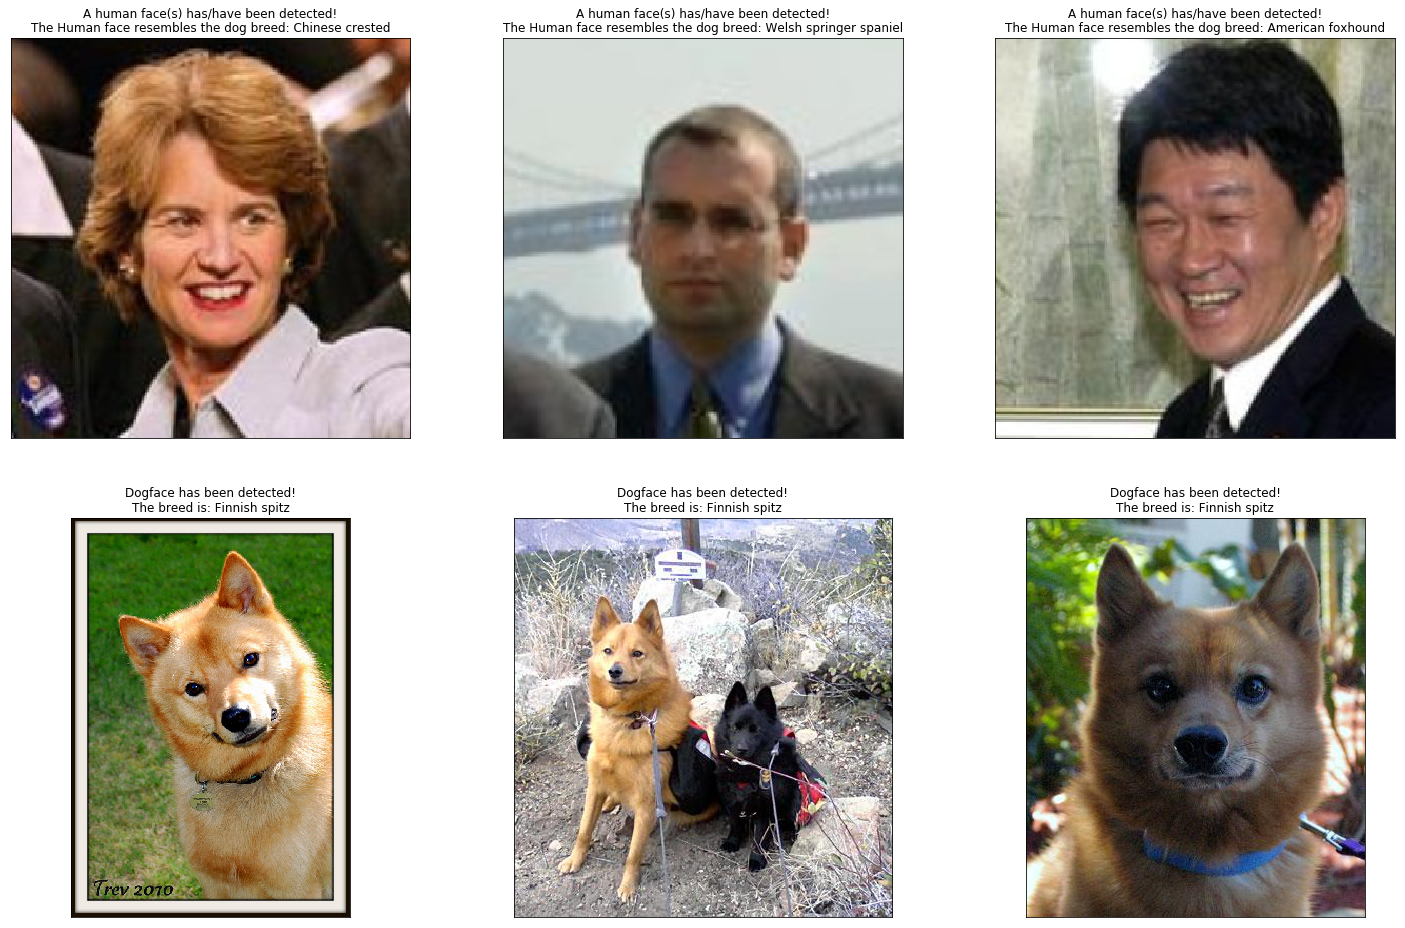

In [74]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

fig = plt.figure(figsize=(25, 25))

list_imgs = []
for file in np.hstack((human_files[-3:], dog_files[-3:])):
    list_imgs.append(file)

for idx in np.arange(6):
    msg = run_app(list_imgs[idx])
    img = Image.open(list_imgs[idx])
    ax = fig.add_subplot(3,6/2, idx+1,  xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(msg)


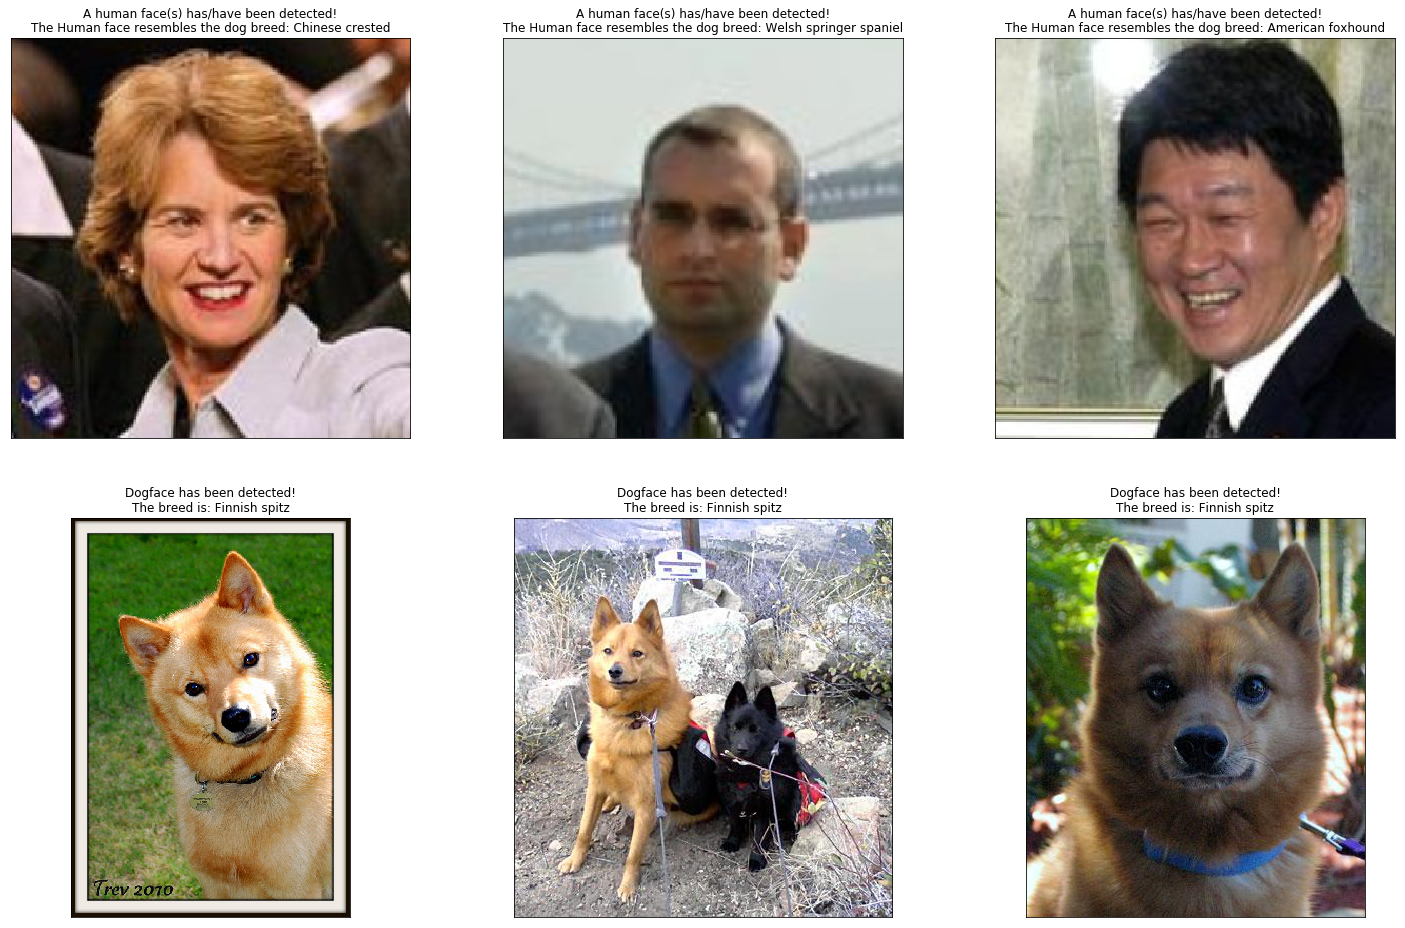

In [76]:

fig = plt.figure(figsize=(25,25))

list_imgs = []
for file in np.hstack((human_files[-3:], dog_files[-3:])):
    list_imgs.append(file)

for idx in np.arange(6):
    msg = run_app2(list_imgs[idx])
    img = Image.open(list_imgs[idx])
    ax = fig.add_subplot(3,6/2, idx+1,  xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(msg)
